In [1]:
from typing import List, Tuple, Dict

import cv2
import scipy
import pydicom
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

from tqdm import tqdm
from tqdm.contrib.concurrent import process_map
from scipy.stats import pearsonr
from pydicom.filereader import dcmread
from pathlib import Path
from pydicom import FileDataset

from patient import Patient
from src.utils import (
    best_rect,
    resample_instances,
    perform_windowing,
    make_mask,
)
from src.constants import DATA_DIR, TRAIN_DIR, BASE_AGE, PATIENT_PATHS

/Users/parthshah/.pyenv/versions/3.10.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv(DATA_DIR / "train.csv")
print(train_df.head())

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00007637202177411956430      5  2214  55.712129   79  Male     Ex-smoker
2  ID00007637202177411956430      7  2061  51.862104   79  Male     Ex-smoker
3  ID00007637202177411956430      9  2144  53.950679   79  Male     Ex-smoker
4  ID00007637202177411956430     11  2069  52.063412   79  Male     Ex-smoker


In [3]:
"""When 'Weeks' has a negative value, it means the measurement was taken some weeks before the established "baseline" time point.
So, a value of -4 in the "Weeks" column means the measurement for that patient was taken 4 weeks before the baseline.
It helps in tracking the progression or regression of a certain measure (like "FVC") over time relative to a specific reference point."""

'When \'Weeks\' has a negative value, it means the measurement was taken some weeks before the established "baseline" time point.\nSo, a value of -4 in the "Weeks" column means the measurement for that patient was taken 4 weeks before the baseline.\nIt helps in tracking the progression or regression of a certain measure (like "FVC") over time relative to a specific reference point.'

In [4]:
print(f"Shape of training data is {train_df.shape}")
print()
print(train_df.isna().sum())

Shape of training data is (1549, 7)

Patient          0
Weeks            0
FVC              0
Percent          0
Age              0
Sex              0
SmokingStatus    0
dtype: int64


In [5]:
# No missing values

In [6]:
duplicateEntries = train_df[
    train_df.duplicated(subset=["Patient", "Weeks"], keep=False)
]
# # keep = False means detect all duplicates (including the first & last occurrence)
print(len(duplicateEntries))
print(len(duplicateEntries) / len(train_df))

14
0.009038089089735314


In [7]:
# 0.009% of the data is duplicated we can drop these

In [8]:
train_df = train_df.drop_duplicates(subset=["Patient", "Weeks"], keep=False)

# To perform analysis on the tabular data group by patient and get the first entry
data = train_df.groupby("Patient").first().reset_index()
print(data.head())

                     Patient  Weeks   FVC    Percent  Age   Sex SmokingStatus
0  ID00007637202177411956430     -4  2315  58.253649   79  Male     Ex-smoker
1  ID00009637202177434476278      8  3660  85.282878   69  Male     Ex-smoker
2  ID00010637202177584971671      0  3523  94.724672   60  Male     Ex-smoker
3  ID00011637202177653955184      6  3326  85.987590   72  Male     Ex-smoker
4  ID00012637202177665765362     33  3418  93.726006   65  Male  Never smoked


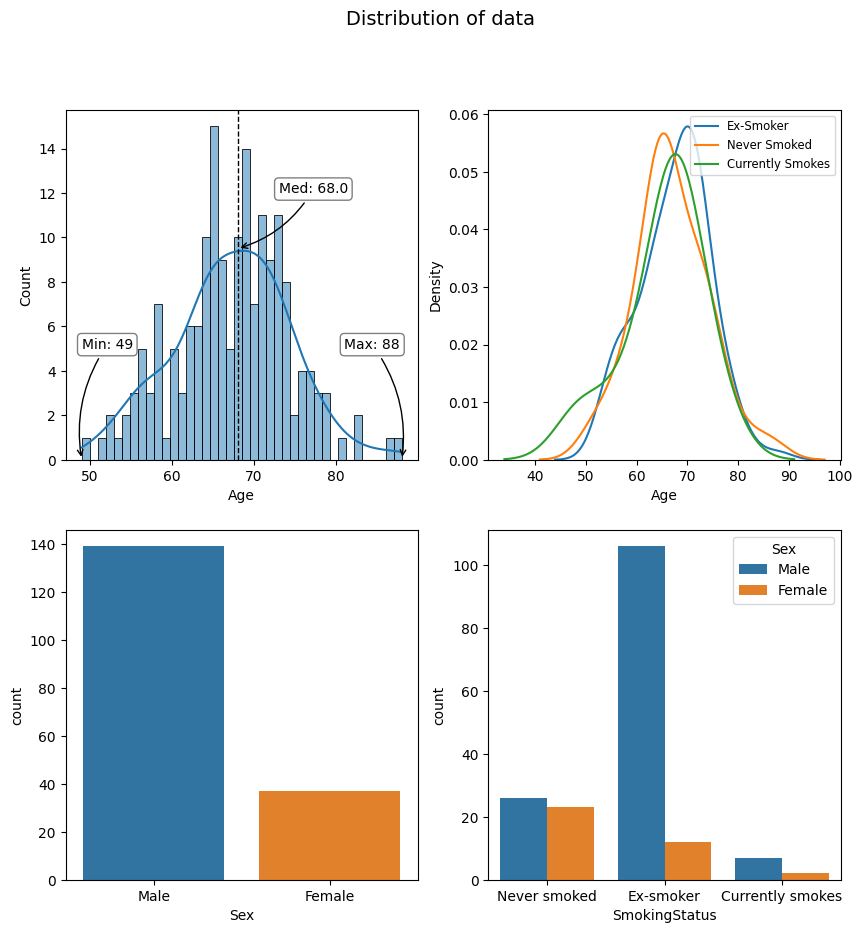

In [9]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(10, 10))
sns.histplot(
    data["Age"], ax=ax0, bins=data["Age"].max() - data["Age"].min() + 1, kde=True
)
ax0.annotate(
    "Min: {:,}".format(data["Age"].min()),
    xy=(data["Age"].min(), 0.005),
    xytext=(data["Age"].min(), 5),
    bbox=dict(boxstyle="round", fc="none", ec="gray"),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=0.2"),
)
ax0.annotate(
    "Max: {:,}".format(data["Age"].max()),
    xy=(data["Age"].max(), 0.005),
    xytext=(data["Age"].max() - 7, 5),
    bbox=dict(boxstyle="round", fc="none", ec="gray"),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=-0.2"),
)
ax0.axvline(x=data["Age"].median(), color="k", linestyle="--", linewidth=1)
ax0.annotate(
    "Med: {:,}".format(data["Age"].median()),
    xy=(data["Age"].median(), 9.5),
    xytext=(data["Age"].max() - 15, 12),
    bbox=dict(boxstyle="round", fc="none", ec="gray"),
    arrowprops=dict(arrowstyle="->", connectionstyle="arc3, rad=-0.2"),
)
sns.kdeplot(
    data[data["SmokingStatus"] == "Ex-smoker"].Age,
    ax=ax1,
    label="Ex-Smoker",
)
sns.kdeplot(
    data[data["SmokingStatus"] == "Never smoked"].Age,
    ax=ax1,
    label="Never Smoked",
)
sns.kdeplot(
    data[data["SmokingStatus"] == "Currently smokes"].Age,
    ax=ax1,
    label="Currently Smokes",
)
ax1.legend(loc="upper right", fontsize="small")
sns.countplot(x="Sex", data=data, ax=ax2)
sns.countplot(
    x="SmokingStatus",
    data=data,
    hue="Sex",
    ax=ax3,
    order=["Never smoked", "Ex-smoker", "Currently smokes"],
)
fig.suptitle("Distribution of data", fontsize=14)
plt.show()

In [10]:
def get_features(df):
    # Normalize with range of 30
    # So if the age is 30, then it will be 0
    # If the age is 60, then it will be 1 and so on..
    features = [(df.Age.values[0] - BASE_AGE) / BASE_AGE]

    if df.Sex.values[0].lower() == "male":
        features.append(0)
    else:
        features.append(1)

    if df.SmokingStatus.values[0] == "Never smoked":
        features.extend([0, 0])
    elif df.SmokingStatus.values[0] == "Ex-smoker":
        features.extend([1, 1])
    elif df.SmokingStatus.values[0] == "Currently smokes":
        features.extend([0, 1])
    else:
        features.extend([1, 0])
    return np.array(features)

In [11]:
# Regress FVC on weeks to get the slope
slope_per_patient = {}
patient_features = {}
patient_ids = []

for i, patient_id in tqdm(enumerate(train_df.Patient.unique())):
    patient_data = train_df.loc[train_df.Patient == patient_id, :]

    # Extract FVC and weeks data
    y = patient_data.FVC.values
    x = patient_data.Weeks.values

    # x -> independent variable
    # m -> slope / weights
    m_x = np.vstack([x, np.ones(len(x))]).T

    # Perform least squares linear regression to find the slope and intercept
    # y = mx + b, where m is the slope and b is the intercept
    # y = fvc_values, x = week_values
    # fvc_values = m * week_values + b
    slope, intercept = np.linalg.lstsq(m_x, y)[0]

    slope_per_patient[patient_id] = slope
    patient_features[patient_id] = get_features(patient_data)
    patient_ids.append(patient_id)

print("Mean slope:", np.mean(list(slope_per_patient.values())))
print("Median slope:", np.median(list(slope_per_patient.values())))
print("Std slope:", np.std(list(slope_per_patient.values())))

0it [00:00, ?it/s]/var/folders/0g/51ngyll510j8j7tlj08dk5m00000gn/T/ipykernel_1635/1212298145.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, intercept = np.linalg.lstsq(m_x, y)[0]
176it [00:00, 3830.00it/s]

Mean slope: -4.489636325452874
Median slope: -3.843892716443512
Std slope: 6.099069502159477


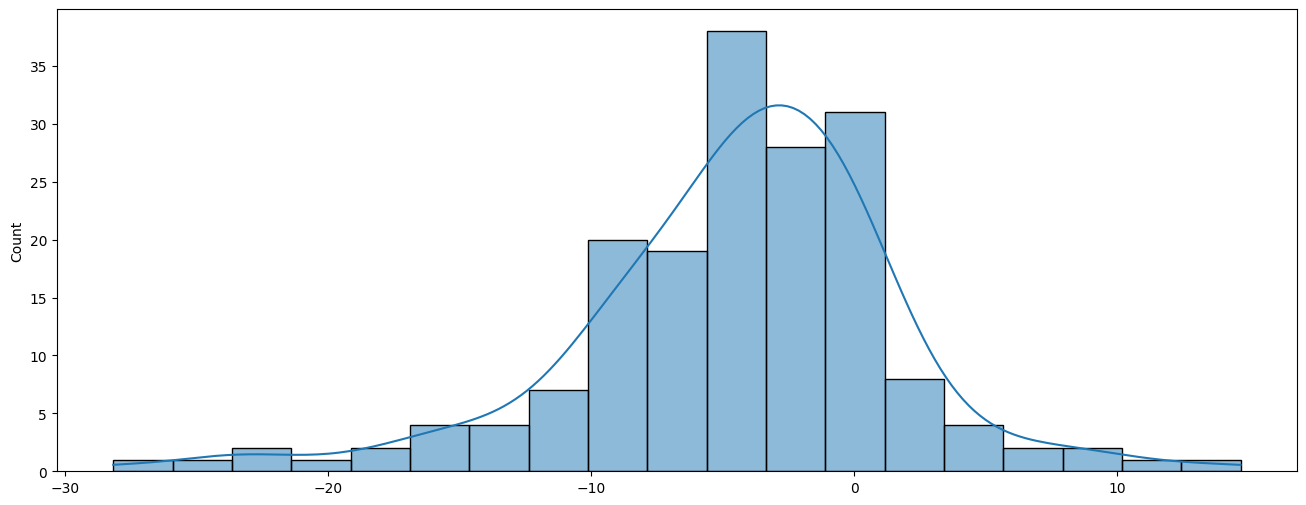

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
sns.histplot(list(slope_per_patient.values()), ax=ax, kde=True)
plt.show()

In [13]:
# The distribution is skewed to the left, meaning that most patients have a negative slope.
# This means that most patients have a decreasing FVC over time. The std is also quite large,
# meaning that there is a lot of variation in the rates of change of FVC across patients.

In [14]:
corr1, _ = pearsonr(data["FVC"], data["Percent"])
corr2, _ = pearsonr(data["FVC"], data["Age"])
corr3, _ = pearsonr(data["Percent"], data["Age"])
print(
    "Pearson Corr FVC x Percent: {:.4}".format(corr1), "\n" +
    "Pearson Corr FVC x Age: {:.0}".format(corr2), "\n" +
    "Pearson Corr Percent x Age: {:.2}".format(corr3)
)

Pearson Corr FVC x Percent: 0.6526 
Pearson Corr FVC x Age: -0.09 
Pearson Corr Percent x Age: 0.11


In [15]:
# The correlation between FVC and Percent is very high, as expected as Percent is calculated using FVC.

Text(0.5, 0.98, 'Correlation between FVC and Age (Pearson Corr: 0.6526)')

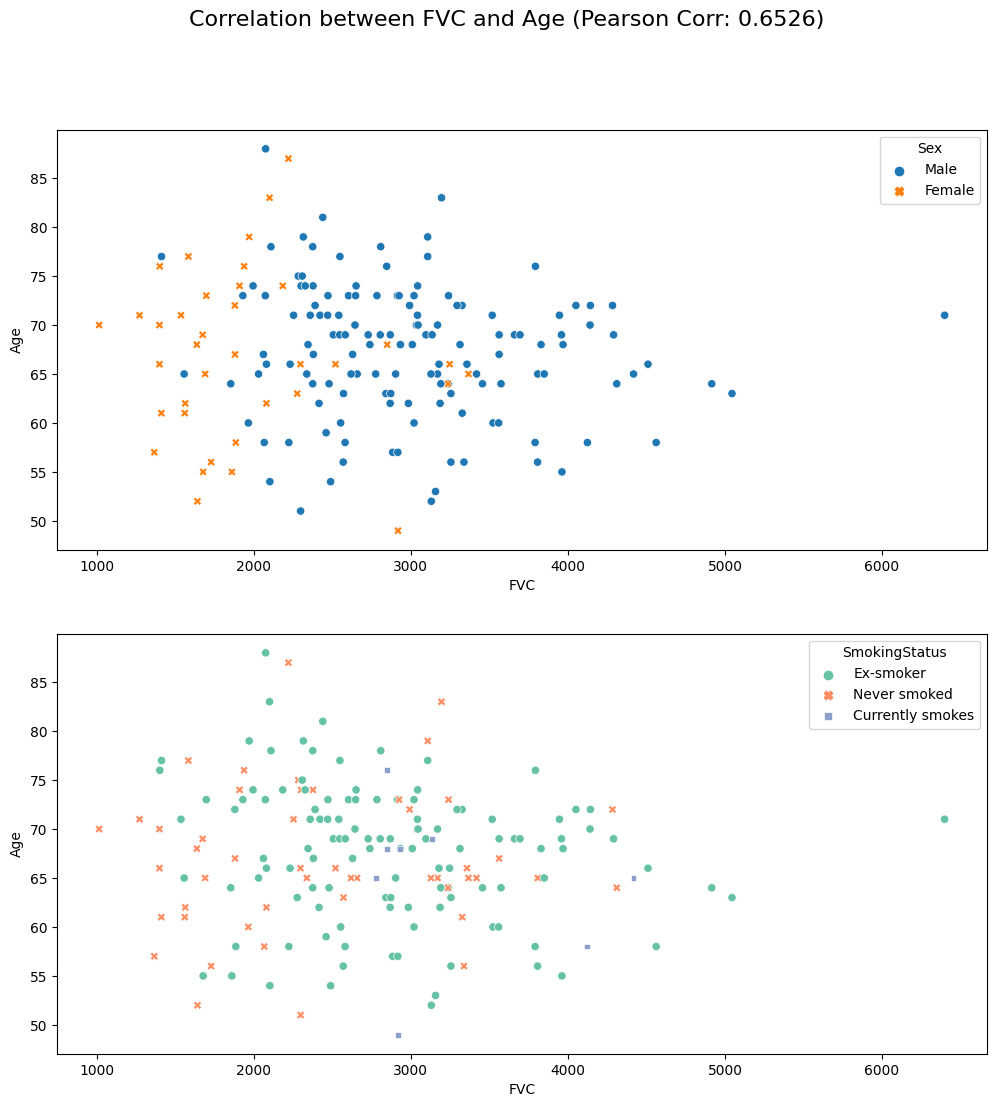

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

sns.scatterplot(x=data["FVC"], y=data["Age"], ax=ax1, hue=data["Sex"], style=data["Sex"])
sns.scatterplot(x=data["FVC"], y=data["Age"], ax=ax2, hue=data["SmokingStatus"], style=data["SmokingStatus"], palette="Set2")

fig.suptitle("Correlation between FVC and Age (Pearson Corr: {:.4f})".format(data["FVC"].corr(data["Percent"])), fontsize=16)

Text(0.5, 0.98, 'Correlation between FVC and Percent (Pearson Corr: 0.6526)')

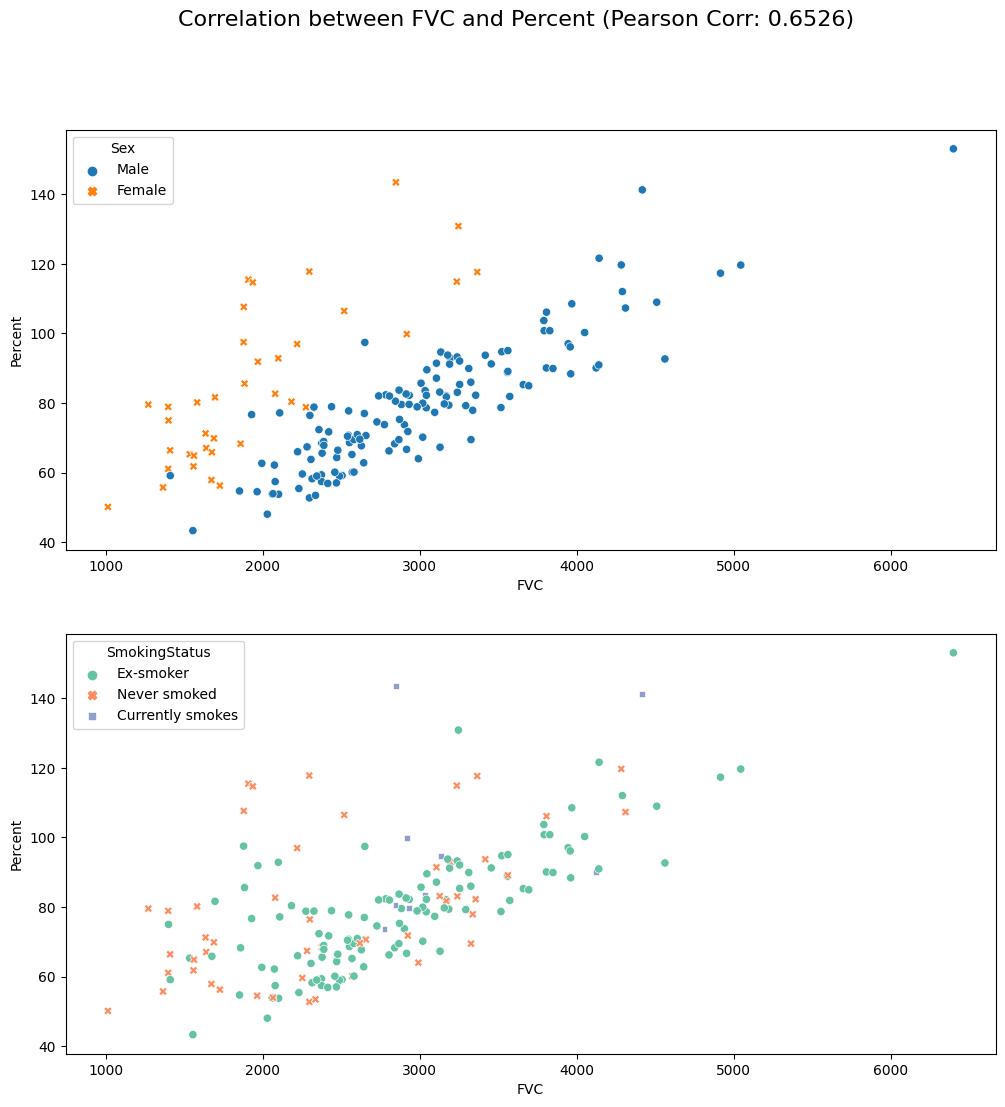

In [17]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

sns.scatterplot(x=data["FVC"], y=data["Percent"], ax=ax1, hue=data["Sex"], style=data["Sex"])
sns.scatterplot(x=data["FVC"], y=data["Percent"], ax=ax2, hue=data["SmokingStatus"], style=data["SmokingStatus"], palette="Set2")

fig.suptitle("Correlation between FVC and Percent (Pearson Corr: {:.4f})".format(data["FVC"].corr(data["Percent"])), fontsize=16)


        Patient Info:
        -------------
        Patient ID                  : ID00007637202177411956430
        Patient Name                : ID00007637202177411956430
        Patient Sex                 : 
        Patient Modality            : CT
        Patient Body Part Examined  : Chest
        Study Instance UID          : 2.25.80896671862726099888461805953012988790
        Data exists                 : True
        


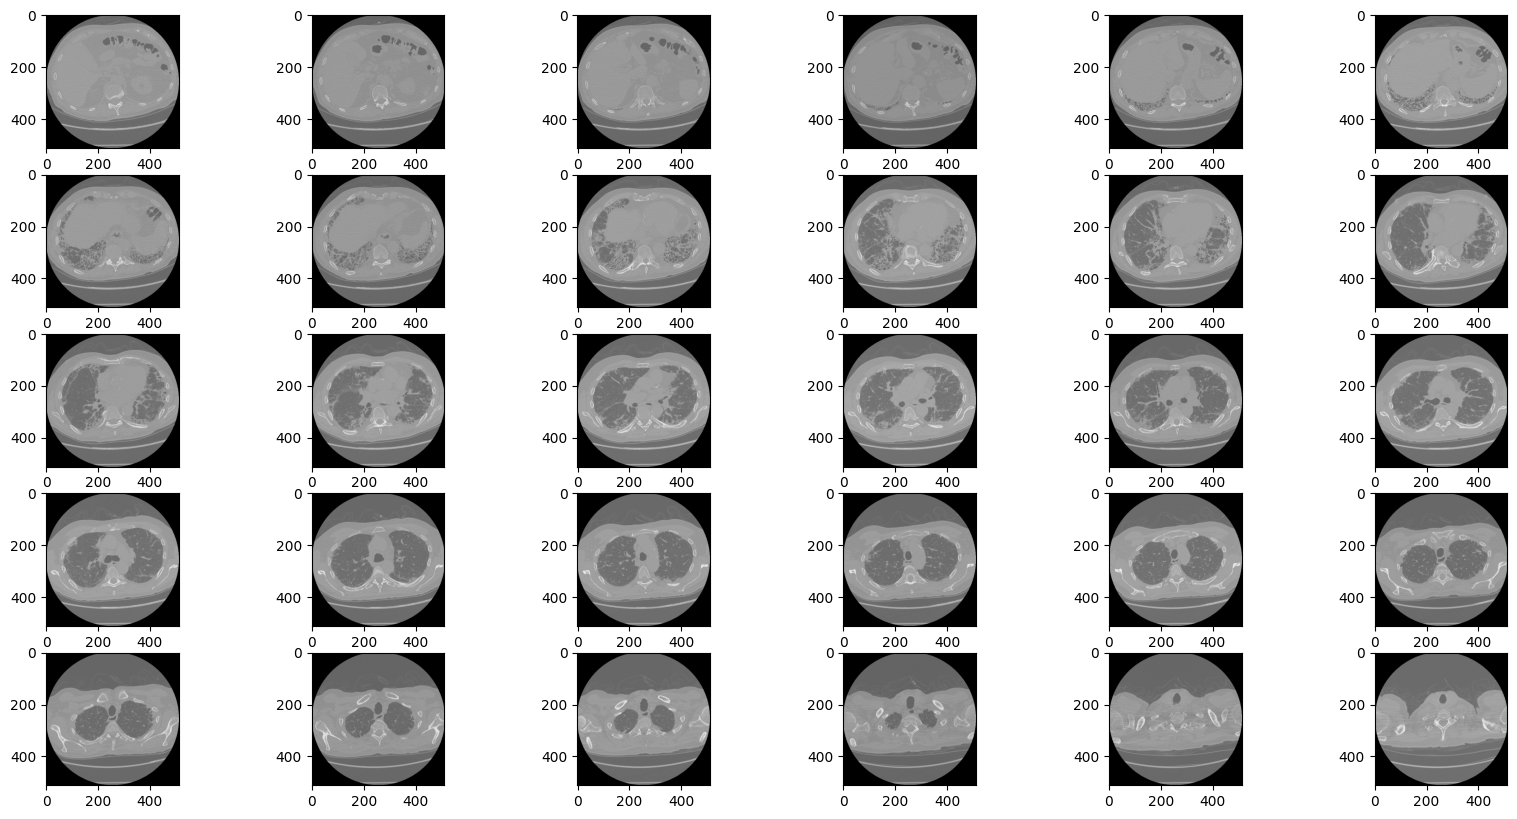


        Patient Info:
        -------------
        Patient ID                  : ID00009637202177434476278
        Patient Name                : ID00009637202177434476278
        Patient Sex                 : 
        Patient Modality            : CT
        Patient Body Part Examined  : Chest
        Study Instance UID          : 2.25.156962683457839326089809785890930019885
        Data exists                 : True
        
Too many slices to display

        Patient Info:
        -------------
        Patient ID                  : ID00010637202177584971671
        Patient Name                : ID00010637202177584971671
        Patient Sex                 : 
        Patient Modality            : CT
        Patient Body Part Examined  : Chest
        Study Instance UID          : 2.25.11726522219678615199208148726917028045
        Data exists                 : True
        
Too many slices to display

        Patient Info:
        -------------
        Patient ID                  : 

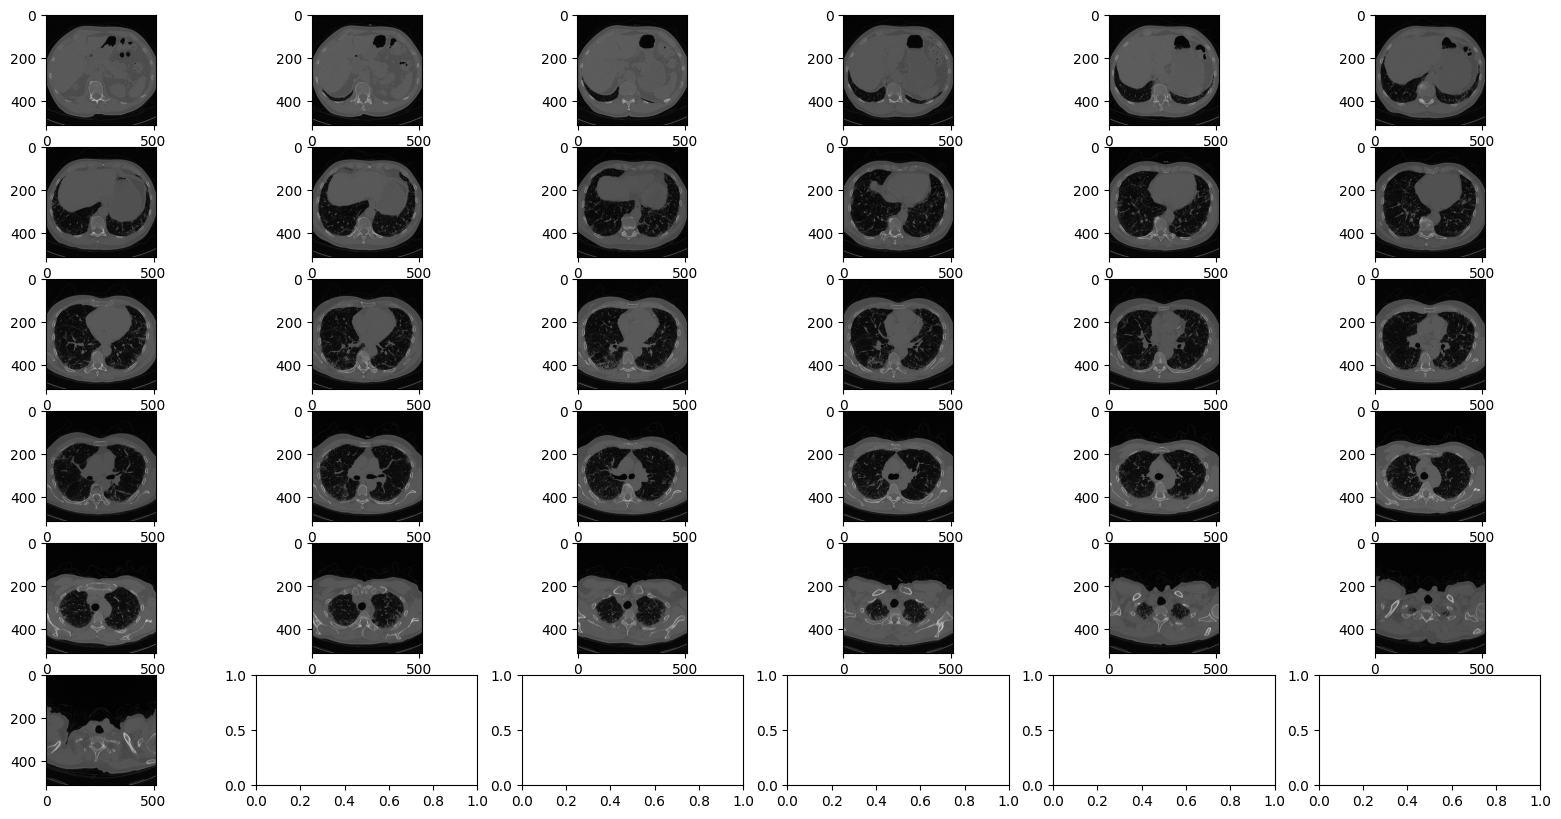

In [18]:
def view_sample_data():
    for patient in PATIENT_PATHS[:5]:
        patient_id = patient.name
        if patient_id.startswith("."):
            continue
        patient = Patient(patient_id)
        print(patient)
        patient.load_scan(display=True)

view_sample_data()